In [152]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from langdetect import detect
import itertools
import string
import collections
from collections import Counter

In [2]:
df = pd.read_csv('reviews.csv')
df

,Customer Review,text
0,Review 1,I travel alot and really enjoyed my stay here....
1,Review 2,Stayed one night for a seminar at the Universi...
2,Review 3,I stayed at the the BW Downtown on two separat...
3,Review 4,This is my first year to go to with a group of...
4,Review 5,I travel with several friends (we're from a sm...
...,...,...
195,Review 196,We try to use any excuse to celebrate a weeken...
196,Review 197,"The Sorella is a nice, contemporary hotel. Qui..."
197,Review 198,Dieses ist immer wieder eines meiner Favourite...
198,Review 199,Sch√∂ne Zimmer und sind sehr gut eingerichtet....


In [4]:
df['word_count'] = df['text'].str.split().apply(len)
df['language'] = df['text'].apply(lambda x: detect(x))
new_df=df.drop(df[df.language != 'en'].index)
new_df

,Customer Review,text,word_count,language
0,Review 1,I travel alot and really enjoyed my stay here....,39,en
1,Review 2,Stayed one night for a seminar at the Universi...,76,en
2,Review 3,I stayed at the the BW Downtown on two separat...,241,en
3,Review 4,This is my first year to go to with a group of...,97,en
4,Review 5,I travel with several friends (we're from a sm...,77,en
...,...,...,...,...
193,Review 194,"Got a Deluxe Room facing the ""green"" to watch ...",61,en
194,Review 195,"The Hotel was super clean, nice modern-retro d...",81,en
195,Review 196,We try to use any excuse to celebrate a weeken...,100,en
196,Review 197,"The Sorella is a nice, contemporary hotel. Qui...",28,en


In [5]:
df['word_count'].describe()
# df_sorted = df.sort_values('word_count', ascending = False)
# fig = plt.figure(figsize=(20,10))
# plt.plot('Customer Review','word_count', data=df_sorted)
# plt.xlabel('Reviews')
# plt.ylabel('Word Count')

# Need to add a boxplot based on statistics

count    200.000000
mean     125.565000
std      100.740703
min       10.000000
25%       60.000000
50%       99.500000
75%      160.500000
max      678.000000
Name: word_count, dtype: float64

In [54]:

wn = WordNetLemmatizer()
ps = nltk.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    text = "".join([word for word in text if not word.isdigit()])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopword]    
    return text

new_df['body_clean'] = new_df['text'].apply(lambda x: clean_text(x.lower())) #Remove punctuation & stopwords, normalized, numbers and tokenized

def stem(stem_text):
    text = [ps.stem(word) for word in stem_text]
    return text

new_df['body_clean_stem'] = new_df['body_clean'].apply(lambda x: stem(x)) #Stemming Performed

def lemmatizer(lem_text):
    text = [wn.lemmatize(word, pos = 'v') for word in lem_text]
    return text

new_df['body_clean_lem'] = new_df['body_clean'].apply(lambda x: lemmatizer(x)) #Lemmatization Performed

#Sentiment Labels
analyser = SentimentIntensityAnalyzer()
def sentiment_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

new_df['sentiment_score'] = new_df['text'].apply(lambda x: sentiment_scores(x)) #Sentiment score provided
new_df['compound_score'] = new_df['sentiment_score'].apply(lambda score_dict: score_dict['compound']) #Extract the compound score
new_df['label'] = new_df['compound_score'].apply(lambda c: 'GOOD' if c >=0 else 'BAD') #Label 'GOOD' if compoud score is greater that 0 and 'BAD' otherwise
new_df['label_code'] = new_df['label'].apply(lambda x: '1' if x == 'GOOD' else '0') #Convert labels to binary (Good - 1, Bad - 0)

new_df

,Customer Review,text,word_count,language,body_clean,body_clean_stem,body_clean_lem,sentiment_score,compound_score,label,label_code
0,Review 1,I travel alot and really enjoyed my stay here....,39,en,"[travel, alot, really, enjoyed, stay, hotel, c...","[travel, alot, realli, enjoy, stay, hotel, cle...","[travel, alot, really, enjoy, stay, hotel, cle...","{'neg': 0.0, 'neu': 0.764, 'pos': 0.236, 'comp...",0.8882,GOOD,1
1,Review 2,Stayed one night for a seminar at the Universi...,76,en,"[stayed, one, night, seminar, university, clea...","[stay, one, night, seminar, univers, clean, co...","[stay, one, night, seminar, university, clean,...","{'neg': 0.022, 'neu': 0.744, 'pos': 0.234, 'co...",0.9554,GOOD,1
2,Review 3,I stayed at the the BW Downtown on two separat...,241,en,"[stayed, bw, downtown, two, separate, business...","[stay, bw, downtown, two, separ, busi, trip, n...","[stay, bw, downtown, two, separate, business, ...","{'neg': 0.023, 'neu': 0.847, 'pos': 0.129, 'co...",0.9781,GOOD,1
3,Review 4,This is my first year to go to with a group of...,97,en,"[first, year, go, group, quilter, southeast, k...","[first, year, go, group, quilter, southeast, k...","[first, year, go, group, quilter, southeast, k...","{'neg': 0.0, 'neu': 0.801, 'pos': 0.199, 'comp...",0.9696,GOOD,1
4,Review 5,I travel with several friends (we're from a sm...,77,en,"[travel, several, friends, small, town, girls,...","[travel, sever, friend, small, town, girl, wee...","[travel, several, friends, small, town, girls,...","{'neg': 0.0, 'neu': 0.749, 'pos': 0.251, 'comp...",0.9701,GOOD,1
...,...,...,...,...,...,...,...,...,...,...,...
193,Review 194,"Got a Deluxe Room facing the ""green"" to watch ...",61,en,"[got, deluxe, room, facing, green, watch, th, ...","[got, delux, room, face, green, watch, th, jul...","[get, deluxe, room, face, green, watch, th, ju...","{'neg': 0.0, 'neu': 0.77, 'pos': 0.23, 'compou...",0.9300,GOOD,1
194,Review 195,"The Hotel was super clean, nice modern-retro d...",81,en,"[hotel, super, clean, nice, modernretro, desig...","[hotel, super, clean, nice, modernretro, desig...","[hotel, super, clean, nice, modernretro, desig...","{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'comp...",0.9857,GOOD,1
195,Review 196,We try to use any excuse to celebrate a weeken...,100,en,"[try, use, excuse, celebrate, weekend, hotel, ...","[tri, use, excus, celebr, weekend, hotel, sore...","[try, use, excuse, celebrate, weekend, hotel, ...","{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp...",0.9688,GOOD,1
196,Review 197,"The Sorella is a nice, contemporary hotel. Qui...",28,en,"[sorella, nice, contemporary, hotel, quiet, ho...","[sorella, nice, contemporari, hotel, quiet, ho...","[sorella, nice, contemporary, hotel, quiet, ho...","{'neg': 0.0, 'neu': 0.814, 'pos': 0.186, 'comp...",0.6908,GOOD,1


In [68]:
all_words = new_df['body_clean_lem'].tolist()
all_words_2 = list(itertools.chain(*all_words))
counts_all_words_2 = collections.Counter(all_words_2)
common_words = pd.DataFrame(counts_all_words_2.most_common(), columns=['words', 'count']) #gets the most common words in all of the documents
common_words

,words,count
0,hotel,317
1,room,263
2,stay,211
3,staff,150
4,great,121
...,...,...
2663,wspa,1
2664,develop,1
2665,suprised,1
2666,sportsfitness,1


In [69]:
# Creates the TF matrix 
count_vect  = CountVectorizer(max_features = 2000, min_df = 5, max_df = 0.7, analyzer = lemmatizer) #analyzer hyperparameter directly runs the fuction created
X_count_vect = count_vect.fit_transform(new_df['body_clean_lem'])
X_count_df = pd.DataFrame(X_count_vect.toarray()) #changes sparse matrix into an array 
X_count_df.columns = count_vect.get_feature_names()
tf_mat = X_count_df.div(X_count_df.sum(axis = 1), axis = 0) #Divides all the values within the matrix by the sum of each document
tf_mat

,able,absolutely,access,accommodate,across,actually,adequate,afternoon,air,airport,...,wont,work,world,worth,would,year,yogurt,york,youre,äôs
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.032258,0.000000,...,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.024096,0.000000,0.0,0.0,0.0,0.0,0.000000,0.012048,...,0.0,0.012048,0.0,0.012048,0.00,0.000000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.076923,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00,0.115385,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00,0.071429,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.040000,0.04,0.000000,0.0,0.0,0.000000,0.0
188,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.0
189,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00,0.029412,0.0,0.0,0.000000,0.0
190,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.0


In [81]:
# Creates the TF-IDF matrix 
tfidf_vect = TfidfVectorizer(max_features = 2000, min_df = 5, max_df = 0.7, analyzer = lemmatizer) #analyzer hyperparameter directly runs the fuction created
X_tfidf = tfidf_vect.fit_transform(new_df['body_clean_lem']).toarray()
X_tfidf_df.columns = tfidf_vect.get_feature_names()
X_tfidf_df

,able,absolutely,access,accommodate,across,actually,adequate,afternoon,air,airport,...,wont,work,world,worth,would,year,yogurt,york,youre,äôs
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.224698,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.209551,0.000000,0.0,0.0,0.0,0.0,0.000000,0.122316,...,0.0,0.088609,0.0,0.115195,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.367003,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.538841,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.389282,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.195505,0.118108,0.000000,0.0,0.0,0.000000,0.0
188,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
189,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.175905,0.0,0.0,0.000000,0.0
190,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [145]:
X = X_tfidf
y = new_df.iloc[:, 10].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

rfc = RandomForestClassifier(n_estimators = 100, max_depth=4, random_state = 42)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print(classification_report(y_test, y_pred_rfc))

score1 = f1_score(y_test, y_pred_rfc, average='weighted')
score1

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.97      1.00      0.99        75

    accuracy                           0.97        77
   macro avg       0.49      0.50      0.49        77
weighted avg       0.95      0.97      0.96        77



C:\Users\khasy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9612098427887901

In [146]:
clf = svm.SVC(kernel='rbf',gamma = 'scale', C=10) 
clf.fit(X_train, y_train)
y_pred_SVM = clf.predict(X_test)
print(classification_report(y_test, y_pred_SVM))

score2 = f1_score(y_test, y_pred_SVM, average='weighted')
score2

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.97      1.00      0.99        75

    accuracy                           0.97        77
   macro avg       0.49      0.50      0.49        77
weighted avg       0.95      0.97      0.96        77



C:\Users\khasy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9612098427887901

In [147]:
LogisticReg = LogisticRegression(multi_class = 'multinomial',solver = 'sag', C=10)
LogisticReg.fit(X_train, y_train)
y_pred_logReg = LogisticReg.predict(X_test)
print(classification_report(y_test,y_pred_logReg))  

score3 = f1_score(y_test, y_pred_logReg, average='weighted')
score3

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.97      1.00      0.99        75

    accuracy                           0.97        77
   macro avg       0.49      0.50      0.49        77
weighted avg       0.95      0.97      0.96        77



C:\Users\khasy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9612098427887901

In [154]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb_pred = bnb.predict(X_test)
print(classification_report(y_test,bnb_pred))  
print(confusion_matrix(y_test, bnb_pred))
score3 = f1_score(y_test, bnb_pred, average='weighted')
score3

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.97      0.95      0.96        75

    accuracy                           0.92        77
   macro avg       0.49      0.47      0.48        77
weighted avg       0.95      0.92      0.93        77

[[ 0  2]
 [ 4 71]]


0.9345384345384344

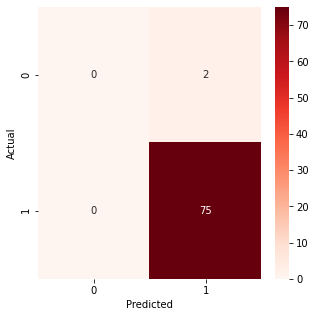

In [148]:
conf_mat1 = confusion_matrix(y_test, y_pred_rfc)

fig, ax3 = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat1, annot=True, fmt='d', cmap = 'Reds',linecolor='black')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

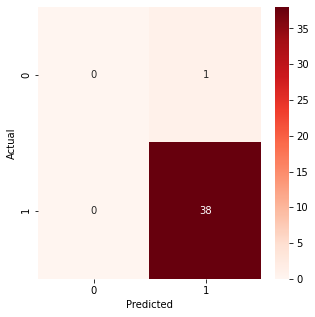

In [127]:
conf_mat2 = confusion_matrix(y_test, y_pred_SVM)

fig, ax3 = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat2, annot=True, fmt='d', cmap = 'Reds',linecolor='black')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

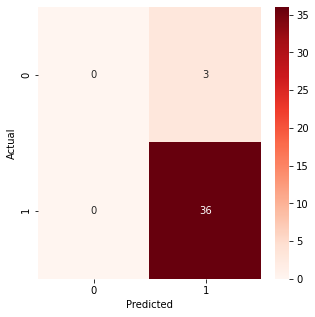

In [137]:
conf_mat3 = confusion_matrix(y_test, y_pred_logReg)

fig, ax3 = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat3, annot=True, fmt='d', cmap = 'Reds',linecolor='black')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

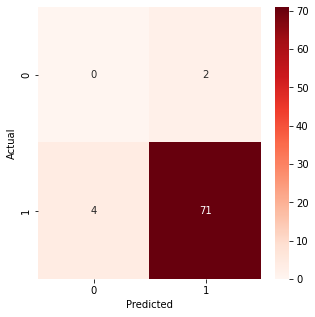

In [155]:
conf_mat4 = confusion_matrix(y_test, bnb_pred)

fig, ax3 = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat4, annot=True, fmt='d', cmap = 'Reds',linecolor='black')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [167]:
new_df['label'].value_counts()

GOOD    185
BAD       7
Name: label, dtype: int64

In [181]:
counter_train=collections.Counter(y_train)
print(counter_train)
counter_test=collections.Counter(y_test)
print(counter_test)


Counter({'1': 110, '0': 5})
Counter({'1': 75, '0': 2})


In [ ]:
tf_value = tf_mat['room'].sum(axis = 0)
tfidf_value = X_tfidf_df['room'].sum(axis = 0)
print(tf_value)
print(tfidf_value)